# Supervised Machine Learning

In [2]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from tensorflow import keras 
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load the filtered dataset
accident = pd.read_csv("./Processed_data/filtered_accident.csv")

# Map to multi-class
def relabel(row):
    if row in [0, 1]:
        return 0  # Class 0
    elif row in [2, 3]:
        return 1  # Class 1
    elif row >= 4:
        return 2  # Class 2
    else:
        return -1

# Apply to your target column
accident['TARGET_MULTI'] = accident['NUM_INJURED'].apply(relabel)

accident = accident[accident['TARGET_MULTI'] != -1]

# Drop unused
accident = accident.drop(columns=['FATALS', 'ST_CASE', 'NUM_INJURED'])

In [ ]:
# Split into features and target
X = accident.drop(columns=['TARGET_MULTI'])
y = accident['TARGET_MULTI']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Downsample class 0 and 1 to match the minority class 2
under = RandomUnderSampler(sampling_strategy={0: 5000, 1: 5000}, random_state=42)

# SMOTE to upsample for class 2
smote = SMOTE(sampling_strategy={2: 5000}, random_state=42, k_neighbors=3)

pipeline = Pipeline(steps=[
    ('under', under),
    ('smote', smote)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
print(len(y_resampled))
print(len(y_test))

15000
3262


In [ ]:
# SVM

# Initialize SVM classifier
svm_clf = SVC(random_state=42)

# Hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    # 'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    # 'degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(estimator=svm_clf, param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=2)
# Fit the model
grid_search_svm.fit(X_resampled, y_resampled)

# Predictions and evaluation
y_pred = grid_search_svm.best_estimator_.predict(X_test)

# Best parameters
print("Best Parameters:", grid_search_svm.best_params_)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10, 'kernel': 'linear'}
Confusion Matrix:
[[1372  425   92]
 [  82  860  136]
 [   2   12  281]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1889
           1       0.66      0.80      0.72      1078
           2       0.55      0.95      0.70       295

    accuracy                           0.77      3262
   macro avg       0.72      0.83      0.75      3262
weighted avg       0.81      0.77      0.78      3262



SVM : 77%

Best Parameters: {'C': 10, 'kernel': 'linear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82      1889
           1       0.66      0.80      0.72      1078
           2       0.55      0.95      0.70       295

    accuracy                           0.77      3262
   macro avg       0.72      0.83      0.75      3262
weighted avg       0.81      0.77      0.78      3262

In [6]:
# LDA

lda = LinearDiscriminantAnalysis()

param_grid_lda = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto'],
    'n_components': [None, 1, 2]
}

grid_search_lda = GridSearchCV(lda, param_grid=param_grid_lda, cv=5, n_jobs=-1, verbose=2)

grid_search_lda.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search_lda.best_params_)

# Predictions and evaluation
y_pred = grid_search_lda.best_estimator_.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}
Confusion Matrix:
[[1405  428   56]
 [ 284  710   84]
 [  12   42  241]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1889
           1       0.60      0.66      0.63      1078
           2       0.63      0.82      0.71       295

    accuracy                           0.72      3262
   macro avg       0.69      0.74      0.71      3262
weighted avg       0.73      0.72      0.73      3262



LDA:
Best Parameters: {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      1889
           1       0.60      0.66      0.63      1078
           2       0.63      0.82      0.71       295

    accuracy                           0.72      3262
   macro avg       0.69      0.74      0.71      3262
weighted avg       0.73      0.72      0.73      3262


In [7]:
# QDA

qda = QuadraticDiscriminantAnalysis()

param_grid_qda = {
    'reg_param': [0, 0.001, 0.01, 0.05, 0.1, 0.012, 0.15, 0.0175, 0.2, 0.25, 0.5]
}

grid_search_qda = GridSearchCV(qda, param_grid=param_grid_qda, cv=5, n_jobs=-1, verbose=2)

grid_search_qda.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search_qda.best_params_)

# Predictions and evaluation
y_pred = grid_search_qda.best_estimator_.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best Parameters: {'reg_param': 0.15}
Confusion Matrix:
[[1321  507   61]
 [ 106  875   97]
 [   3   92  200]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1889
           1       0.59      0.81      0.69      1078
           2       0.56      0.68      0.61       295

    accuracy                           0.73      3262
   macro avg       0.69      0.73      0.70      3262
weighted avg       0.78      0.73      0.74      3262



QDA:
Best Parameters: {'reg_param': 0.15}

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1889
           1       0.59      0.81      0.69      1078
           2       0.56      0.68      0.61       295

    accuracy                           0.73      3262
   macro avg       0.69      0.73      0.70      3262
weighted avg       0.78      0.73      0.74      3262


In [ ]:
# Random Forest

# Define
rf_clf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
param_grid_rf = {
    'n_estimators': [25, 50, 75, 100, 120, 150, 170],
    'max_depth': [None, 2, 5, 7, 10, 12, 15],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Grid search
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search_rf.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search_rf.best_params_)

# Predictions and evaluation
y_pred = grid_search_rf.best_estimator_.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 1764 candidates, totalling 8820 fits
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 170}
Confusion Matrix:
[[1447  369   73]
 [  58  868  152]
 [   0    6  289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1889
           1       0.70      0.81      0.75      1078
           2       0.56      0.98      0.71       295

    accuracy                           0.80      3262
   macro avg       0.74      0.85      0.77      3262
weighted avg       0.84      0.80      0.81      3262



RF: 
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1889
           1       0.69      0.81      0.75      1078
           2       0.60      0.96      0.74       295

    accuracy                           0.80      3262
   macro avg       0.75      0.85      0.78      3262
weighted avg       0.83      0.80      0.81      3262

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 170}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1889
           1       0.70      0.81      0.75      1078
           2       0.56      0.98      0.71       295

    accuracy                           0.80      3262
   macro avg       0.74      0.85      0.77      3262
weighted avg       0.84      0.80      0.81      3262


In [9]:
# MLP sklearn

param_grid = {
    'hidden_layer_sizes': [(256, 128, 64, 32)],
    'activation': ['relu','tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    # 'learning_rate': ['constant', 'adaptive'],
    # 'batch_size': [32, 128, 200]
}

grid_search_mlp = GridSearchCV(MLPClassifier(max_iter=2000, early_stopping=True, random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search_mlp.fit(X_resampled, y_resampled)

# Best parameters
print("Best Parameters:", grid_search_mlp.best_params_)

# Predictions and evaluation
y_pred = grid_search_mlp.best_estimator_.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (256, 128, 64, 32), 'solver': 'adam'}
Confusion Matrix:
[[1434  394   61]
 [  65  891  122]
 [   2   19  274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1889
           1       0.68      0.83      0.75      1078
           2       0.60      0.93      0.73       295

    accuracy                           0.80      3262
   macro avg       0.75      0.84      0.77      3262
weighted avg       0.83      0.80      0.80      3262



NN sklearn:

Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (256, 128, 64, 32), 'solver': 'adam'}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1889
           1       0.68      0.83      0.75      1078
           2       0.60      0.93      0.73       295

    accuracy                           0.80      3262
   macro avg       0.75      0.84      0.77      3262
weighted avg       0.83      0.80      0.80      3262


In [26]:
X_train_res, X_val_res, y_train_res, y_val_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Build the model
model = models.Sequential([
    layers.Input(shape=(X_resampled.shape[1],)),
    layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.2),
    layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.2),
    layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.2),
    layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
    # layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_resampled, y_resampled, epochs=1000, callbacks=[early_stopping]) #, validation_data=(X_val_res, y_val_res)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,427 (185.26 KB)

 Trainable params: 47,427 (185.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4676 - loss: 2.7263
Epoch 2/1000
122/469 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7606 - loss: 0.8377

C:\Users\Thunderup\AppData\Roaming\Python\Python310\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7560 - loss: 0.8178
Epoch 3/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7626 - loss: 0.7155
Epoch 4/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7828 - loss: 0.6636
Epoch 5/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7770 - loss: 0.6531
Epoch 6/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7743 - loss: 0.6521
Epoch 7/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7924 - loss: 0.6210
Epoch 8/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7824 - loss: 0.6325
Epoch 9/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7899 - loss: 0.6127
Epoch 10/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7715 - loss: 0.6345
Epoch 11/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7835 - loss: 0.6243
Epoch 12/1000
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7989 - loss: 0.5955
Epoch 13/1000
469/469 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
importances = grid_search_rf.best_estimator_.feature_importances_

# Sort input features by importance
sorted_indices = np.argsort(-importances)

for index in sorted_indices:
    print(f"Feature {X_train.columns[index]} importance: {importances[index]}")

Feature PERSONS importance: 0.576415014388522
Feature VE_TOTAL importance: 0.08702219032540885
Feature PEDS importance: 0.06725350151864877
Feature LATITUDE importance: 0.037950469936494105
Feature LONGITUD importance: 0.03625687700048503
Feature REL_ROAD importance: 0.033173014997943076
Feature COUNTY importance: 0.03193257246633871
Feature HOUR importance: 0.026608424466606915
Feature STATE importance: 0.022402627586497897
Feature FUNC_SYS importance: 0.01838137355150497
Feature DAY_WEEK importance: 0.01777546497494336
Feature ROUTE importance: 0.016151265721622322
Feature LGT_COND importance: 0.011843103869262411
Feature TYP_INT importance: 0.009146330218165133
Feature WEATHER importance: 0.0076877689775564926


In [ ]:
# Permutation importance
perm_importance = permutation_importance(grid_search_mlp.best_estimator_, X_test, y_test, n_repeats=20, random_state=42)
sorted_perm_indices = np.argsort(-perm_importance.importances_mean)

for index in sorted_perm_indices:
    print(f"Feature {X_train.columns[index]} importance: {perm_importance.importances_mean[index]}")

Feature PERSONS importance: 0.3236664622930717
Feature PEDS importance: 0.08165236051502142
Feature REL_ROAD importance: 0.027651747394236627
Feature VE_TOTAL importance: 0.00889025137952173
Feature LONGITUD importance: 0.004935622317596538
Feature COUNTY importance: 0.004828326180257481
Feature STATE importance: 0.0048283261802574695
Feature FUNC_SYS importance: 0.002084610668301623
Feature HOUR importance: 0.001961986511342706
Feature TYP_INT importance: 0.0012722256284487643
Feature LGT_COND importance: 0.0012568976088289164
Feature ROUTE importance: 0.001226241569589176
Feature LATITUDE importance: 0.0010269773145309246
Feature DAY_WEEK importance: 0.0004138565297363339
Feature WEATHER importance: 6.131207847943631e-05


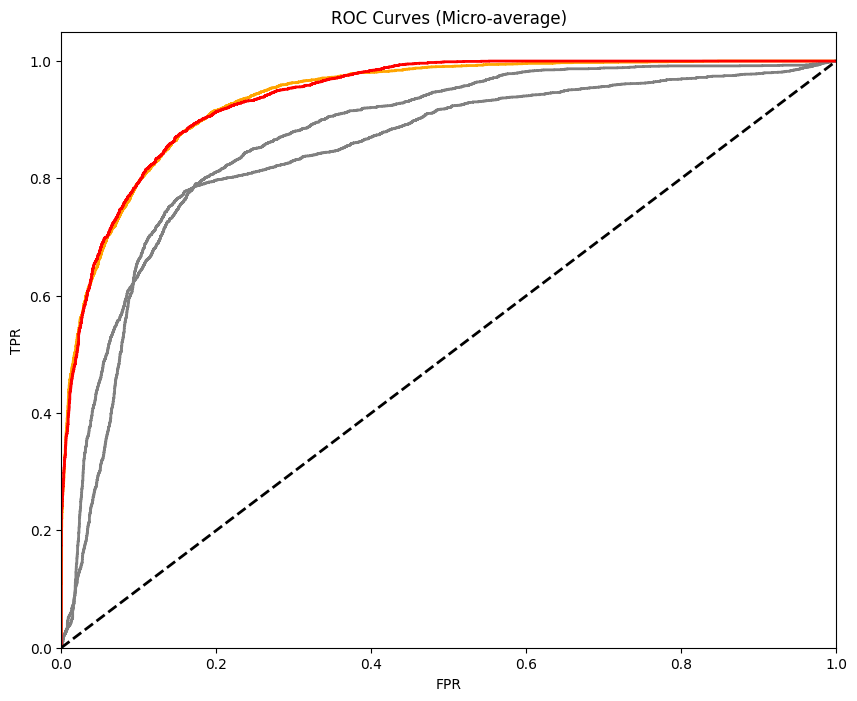

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

models = {'Random Forest': grid_search_rf.best_estimator_, 'LDA': grid_search_lda.best_estimator_,
          'QDA': grid_search_qda.best_estimator_, 'Neural Net': grid_search_mlp.best_estimator_}

n_classes = len(np.unique(y_test))

# Binarize labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_score = model.predict_proba(X_test)
    
    # Micro average ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    if model_name == 'Neural Net':
        color = 'red'
    elif model_name == 'Random Forest':
        color = 'orange'
    else:
        color = 'gray'

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves (Micro-average)')
plt.savefig('./img/roc_comparison.png', dpi=800, bbox_inches='tight')
plt.show()
